# TODO: 

- look to see if anyone has perfected method for correlating gene expression against a phenotype/trait at single cell scale.
- REPEAT PROCESS FOR GEP 22, SEND CSVS TO HOJUN. make pandas code cleaner/reusable. incorporate correction for zero inflation?
- calculate p values for each correlation (HSC, gene, GEP vs progenitor, gene, GEP). basically same thing as task 1, but separate HSCs and progenitor.
- make CDFs color coded. add to dataframe boolean columns whether the correlations are significant or not. use the scipy correlation correction thing above

In [1]:
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np

from scipy.stats import pearsonr, false_discovery_control

import matplotlib.pyplot as plt
import seaborn as sns

# from sklearn.linear_model import ElasticNetCV, LinearRegression
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.pipeline import make_pipeline
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import FunctionTransformer

In [2]:
target_GEP = 'GEP 15 (DNA Replication)'
# target_GEP = 'GEP 22 (Cell cycle)'

In [3]:
def read_metadata():
    return pd.read_csv('./data/metadata.csv').rename(columns={'Unnamed: 0': 'cell'}).set_index('cell')

def read_full_counts():
    adata = sc.read_h5ad("./data/hultcd34_full.h5ad")
    adata.obs = metadata
    df = adata.to_df()
    return df.merge(metadata, left_index=True, right_index=True)

# account for cells thrown out in cell-GEP dataframe, also keep only HSCs and progenitors
def filter_full_counts(df):
    cell_GEP_mapping = read_cell_GEP()
    gep_set = set(cell_GEP_mapping.index)
    raw_counts_set = set(df.index)
    difference = raw_counts_set.difference(gep_set)
    
    df = df[~df.index.isin(difference)]
    df = (df
          [(df['cluster'] != 'Uncommitted') | (df['subcluster'] == 'HSC')]
          .iloc[:, :-9]
         )
    
    return df

def read_cell_GEP():
    cell_GEP_mapping = pd.read_csv(r'./data/Factorized matrices from human lifetime scRNA(GEP usage per cell).csv').set_index('Cell')
    return cell_GEP_mapping.merge(metadata, left_index=True, right_index=True)
    
# keep only HSCs and progenitors
def filter_cell_GEP(cell_GEP_mapping):
    cell_GEP_mapping = (cell_GEP_mapping
                    [(cell_GEP_mapping['cluster'] != 'Uncommitted') | (cell_GEP_mapping['subcluster'] == 'HSC')]
                    .iloc[:, :35]
                   )
    return cell_GEP_mapping

In [4]:
def get_merged(df, cell_GEP_mapping):
    target = cell_GEP_mapping[[target_GEP]]
    df = (df
          .merge(target, left_index=True, right_index=True)
          .merge(metadata, left_index=True, right_index=True)
          )
    return df

def get_HSC(merged):
    hsc = merged[merged['subcluster'] == 'HSC'].iloc[:, :-9]
    hsc_X = hsc.iloc[:, :-1]
    hsc_y = hsc[target_GEP]
    return hsc_X, hsc_y

def get_prog(merged):
    prog = merged[merged['cluster'] != 'Uncommitted'].iloc[:, :-9]
    prog_X = prog.iloc[:, :-1]
    prog_y = prog[target_GEP]
    return prog_X, prog_y

In [5]:
def get_stats_hsc(col):
    X = col
    y = hsc_y
    r, p_val = pearsonr(X, y)
    hsc_res.append({'gene': col.name, 'r hsc': r, 'p hsc': p_val})

def get_stats_prog(col):
    X = col
    y = prog_y
    r, p_val = pearsonr(X, y)
    prog_res.append({'gene': col.name, 'r prog': r, 'p prog': p_val})

In [6]:
# metadata = read_metadata()
# df = (read_full_counts()
#       .pipe(filter_full_counts)
#      )
# cell_GEP_mapping = (read_cell_GEP()
#                     .pipe(filter_cell_GEP)
#                    )

In [7]:
# merged = get_merged(df, cell_GEP_mapping)
# hsc_X, hsc_y = get_HSC(merged)
# prog_X, prog_y = get_prog(merged)

In [8]:
# hsc_res = []
# hsc_X.apply(get_stats_hsc)
# hsc_df = pd.DataFrame(hsc_res).set_index('gene')

# prog_res = []
# prog_X.apply(get_stats_prog)
# prog_df = pd.DataFrame(prog_res).set_index('gene')

# res = hsc_df.merge(prog_df, left_index=True, right_index=True)

In [9]:
# res.to_csv(f'correlations/GEP_{target_GEP[4:6]}_results.csv', index=True)
res = pd.read_csv(f'correlations/GEP_{target_GEP[4:6]}_results.csv').set_index('gene')

In [10]:
# some nans exist in correlations, how to deal?
alpha = 0.05

filtered = res.dropna()
filtered['p adjusted hsc'] = false_discovery_control(filtered['p hsc'])
filtered['p adjusted prog'] = false_discovery_control(filtered['p prog'])
filtered['hsc significant'] = filtered['p adjusted hsc'] < alpha
filtered['prog significant'] = filtered['p adjusted prog'] < alpha
filtered = filtered[['r hsc', 'p hsc', 'p adjusted hsc', 'hsc significant', 'r prog', 'p prog', 'p adjusted prog', 'prog significant']]

/scratch/sbhayani/job_38547160/ipykernel_1714947/2224245022.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['p adjusted hsc'] = false_discovery_control(filtered['p hsc'])
/scratch/sbhayani/job_38547160/ipykernel_1714947/2224245022.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['p adjusted prog'] = false_discovery_control(filtered['p prog'])
/scratch/sbhayani/job_38547160/ipykernel_1714947/2224245022.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [11]:
filtered.head()

,r hsc,p hsc,p adjusted hsc,hsc significant,r prog,p prog,p adjusted prog,prog significant
gene,,,,,,,,
X5S-rRNA,-0.015419,0.142728,0.229862,False,-0.010093,0.070457,0.098964,False
X5-8S-rRNA,-0.015324,0.145208,0.233122,False,-0.005839,0.295298,0.350010,False
X7SK,-0.019402,0.065115,0.124226,False,-0.009996,0.073206,0.102357,False
A1BG,-0.021253,0.043339,0.090221,False,-0.017721,0.001492,0.003085,True
A1BG.AS1,-0.010456,0.320251,0.425414,False,-0.015464,0.005578,0.010223,True


In [12]:
def plot_cdf(df, col_name):
    s = df[col_name]
    cdf = s.rank(method='average', pct=True)
    sorted_s = s.sort_values()
    sorted_cdf = cdf[sorted_s.index]
    
    # Get corresponding significance values
    sig = 'hsc significant' if 'hsc' in col_name else 'prog significant'
    significance = df.loc[sorted_s.index, sig]
    
    # Create the scatter plot with two colors
    plt.figure(figsize=(8, 6))
    for label, color in zip([True, False], ['blue', 'gray']):
        mask = significance == label
        plt.scatter(
            sorted_s[mask].values,
            sorted_cdf[mask].values,
            c=color,
            label='Significant' if label else 'Not Significant',
            alpha=0.4,
        )

    plt.xlabel(col_name)
    plt.ylabel('Cumulative Probability')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

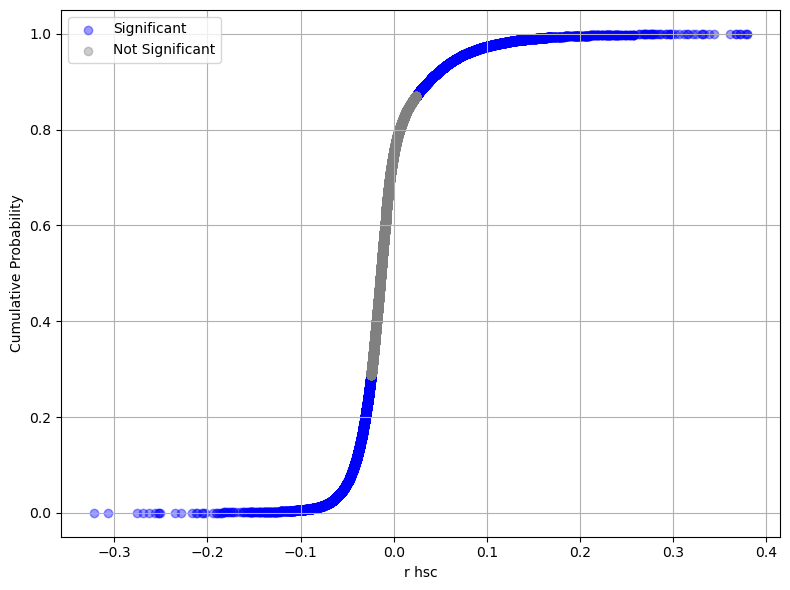

In [13]:
plot_cdf(filtered, 'r hsc')